#### Laurent Jutras-Dubé   


# Infinite-period scenario of Fig. 1


####     

**1. Pattern formation with the infinite-period scenario**

In this notebook, we study the phase model used to generate the results of Fig. 1 B-F. This model assumes that the period of individual oscillators is diverging to infinity (or equivalently that their frequency goes to 0). It is a simplified version of the model from the appendix of the following paper:

Palmeirim, I., Henrique, D., Ish-Horowicz, D., & Pourquié, O. (1997). Avian hairy gene expression identifies a molecular clock linked to vertebrate segmentation and somitogenesis. *Cell*, 91(5), 639-648.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

####     

**1.1 The frequency of the oscillations**

We first define a function that computes the frequency of the oscillations as a function of control parameter $g$, which could for example represent the concentration of a morphogen. Here, we achieve period divergence by letting the frequency decrease quadratically from $\pi/2$ (when $g=1$) to $0$ (when $g=0$).

In [2]:
def compute_omega(g):
    
    return 0.5*np.pi*g**2

####     

**1.2 The spatio-temporal profile of parameter $g$**

In a given cell, the value of $g$ stays equal to 1 for some time (via the `x_osc` parameter) before decreasing exponentially (via the `s` parameter). To generate a spatial pattern, we make the time at which the value of $g$ starts decreasing, $t^*$, dependent on the position $x$ of the cell in the tissue: $t^*(x)$. To model a tissue growing with a constant speed `v`, we make $t^*(x)$ a linear function of $x$.

In [3]:
def compute_g(t, param):
    
    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    positions = np.linspace(0.0, 1.0, param["n_cells"])
    
    g = np.exp(s*(positions +x_osc -v*t))
    g[g > 1.] = 1.
    
    return g

####    

**1.3 The integration scheme** 

We use the Euler integration scheme to perform the integration of the ODE describing the  model. The `integrate` function takes the dictionary of parameters as an input. Parameter `n_steps_keep_results` specifies the number of integration steps between which the simulation results are kept. Increasing this parameter can help reduce the size of the four output matrices, `results`, `g_gradient`, `omega_gradient`, and `times_plot`. These matrices respectively contain the phase of the oscillator at all positions for every time point, the spatio-temporal distribution of parameter $g$, the spatio-temporal profile of the frequency of the oscillator and the array of time points. 

In [4]:
def integrate(param):
    
    # Set the integration parameters
    total_t = param["total_t"]
    dt = param["dt"]
    times = np.arange(0., total_t, dt)
    times_plot = [0.]
   
    counter = 0
    n_skr = param["n_steps_keep_results"]
    
    n_cells = param["n_cells"]
    phi = np.zeros(n_cells) +param["init_phase"]
    results = [np.cos(phi)]
    
    g = compute_g(0., param)
    g_profile = [g]
    
    omega = compute_omega(g)
    omega_profile = [omega]


    # Perform the integration
    for t in times[1:]:
        
        phi = phi +omega*dt
        g = compute_g(t, param)
        omega = compute_omega(g)
        
        counter += 1
        if (counter %n_skr == 0):
            results.append(np.cos(phi))
            g_profile.append(g)
            omega_profile.append(omega)
            times_plot.append(t)
        

    # Output the results
    results = np.array(results)
    g_profile = np.array(g_profile)
    omega_profile = np.array(omega_profile)
    times_plot = np.array(times_plot)
    
    return results, g_profile, omega_profile, times_plot

####     

**1.4 The dynamics of pattern formation** 

We define all the parameters required for the morphogen gradient and for the integration scheme. We then use the `integrate` function to perform the integration. We plot the spatio-temporal profile of the cosine of the phase of the oscillators on a kymograph. We also plot the spatio-temporal profile of parameter $g$ and the relationship between the period of the oscillator and the control parameter $g$. Finally, we plot trajectories of representative cells.

On the kymographs, we plot a line representing the moment at which $g$ starts decreasing for the different positions along the tissue. We also plot lines for the moments at which $g$ reaches specific values, namely $0.5$ and $0.2$. To achieve this, we need to define a function `compute_x` that outputs the position of the cell that has a given value of $g$ at a given time point, and a function `compute_t` that outputs the time at which $g$ has a given value at a given position along the tissue.

In [5]:
param = {
    
    # Parameters for the integration
    "total_t"              : 80.,
    "dt"                   : 0.01,
    "n_steps_keep_results" : 1,
    "n_cells"              : 500,
    "init_phase"           : 0.,
    
    # Parameters for the g profile
    "x_osc" : 0.2,
    "s"     : 0.5,
    "v"     : 0.08
}


results, g_profile, omega_profile, times = integrate(param)

<IPython.core.display.Javascript object>


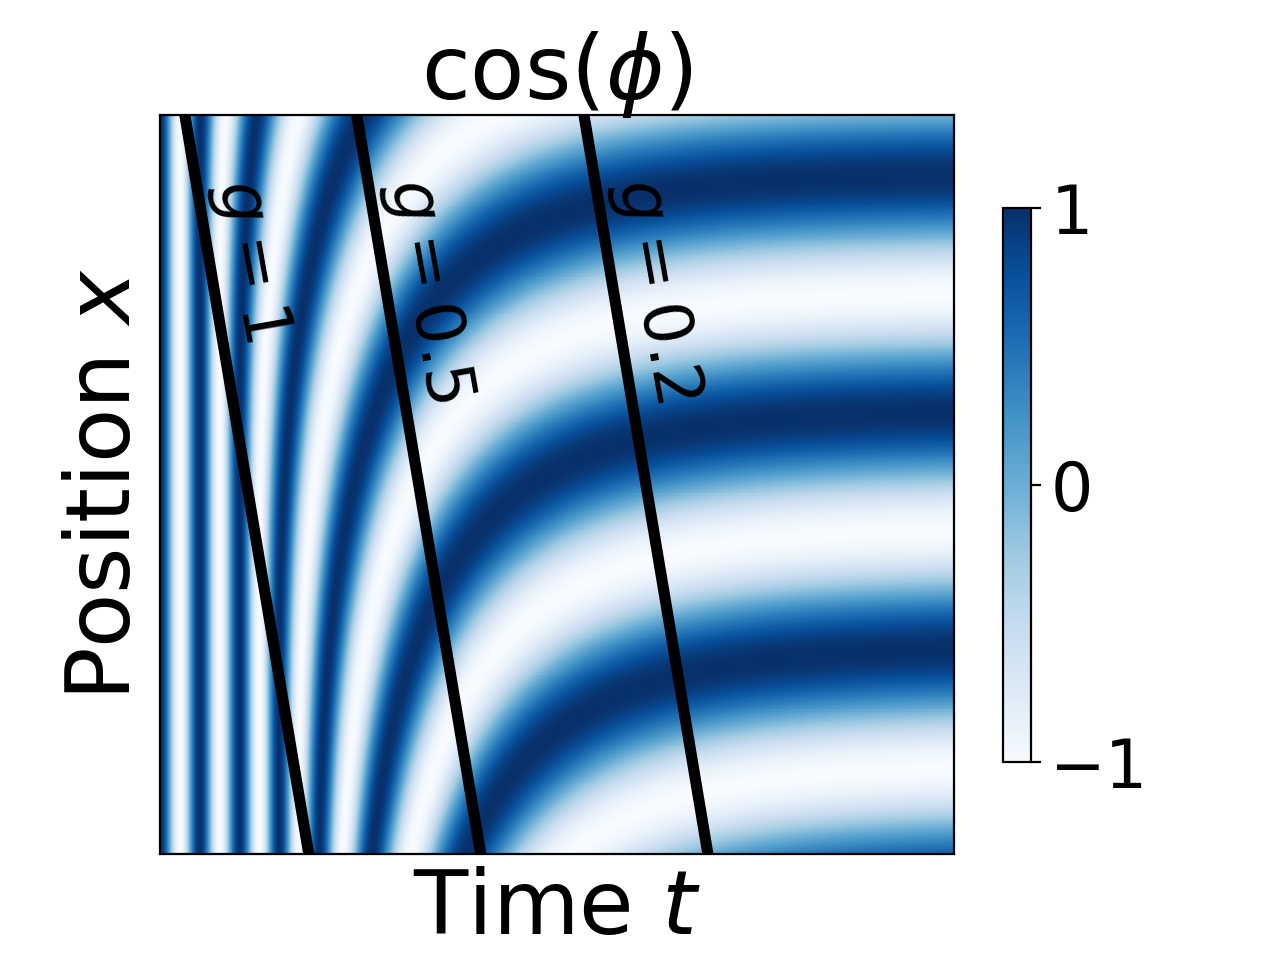

In [6]:
def compute_x(g, t, param):

    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    
    return np.log(g)/s -x_osc +v*t



def compute_t(g, x, param):

    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    
    return (x_osc +x -np.log(g)/s)/v
    

    
# Plot a kymograph of the results
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()
  
# Kymograph
norm = colors.Normalize(vmin=-1., vmax=1.)
kymo = ax.imshow(results.transpose(), norm=norm, cmap='Blues', aspect='auto')
    
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[-1., 0., 1.])
cb.ax.tick_params(labelsize=24)

# Lines of constant g
ax.plot(param["n_cells"]*compute_x(1., times, param), color='k', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.5, times, param), color='k', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.2, times, param), color='k', linewidth=4)
    
ax.text(compute_t(1., 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=1$', color='k', rotation=-80, fontsize=24)
ax.text(compute_t(0.5, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.5$', color='k', rotation=-80, fontsize=24)
ax.text(compute_t(0.2, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.2$', color='k', rotation=-80, fontsize=24)
    
# Other plot options    
ax.set_title('$\cos(\phi)$', fontsize=32)
ax.set_xlabel('Time $t$', fontsize=32)
ax.set_ylabel('Position $x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

<IPython.core.display.Javascript object>


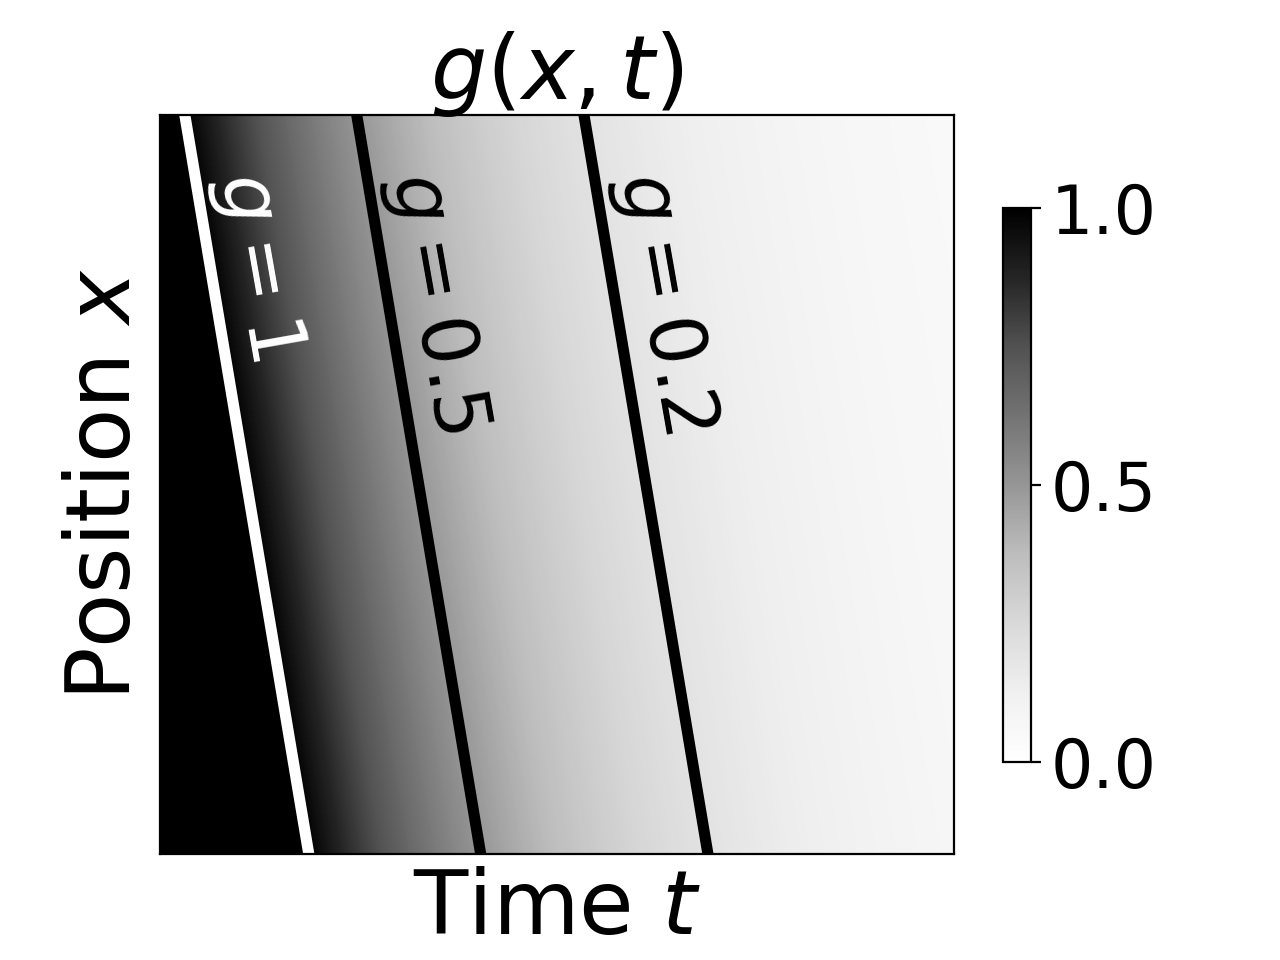

In [7]:
# Generate the kymograph of g
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(g_profile.transpose(), norm=norm, cmap='Greys', aspect='auto')
   
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
    
# Lines of constant g
ax.plot(param["n_cells"]*compute_x(1., times, param), color='w', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.5, times, param), color='k', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.2, times, param), color='k', linewidth=4)
    
ax.text(compute_t(1., 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=1$', color='w', rotation=-80, fontsize=28)
ax.text(compute_t(0.5, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.5$', color='k', rotation=-80, fontsize=28)
ax.text(compute_t(0.2, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.2$', color='k', rotation=-80, fontsize=28)
    
# Other plot options  
ax.set_title('$g(x,t)$', fontsize=32)
ax.set_xlabel('Time $t$', fontsize=32)
ax.set_ylabel('Position $x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

<IPython.core.display.Javascript object>


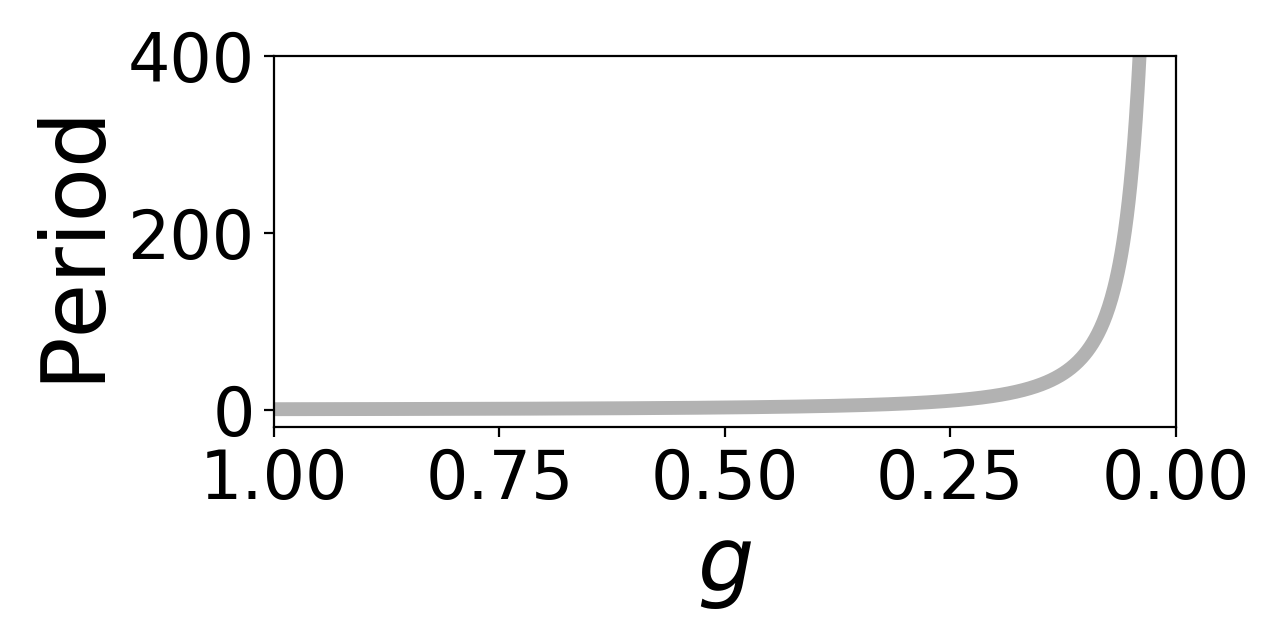

In [8]:
# Plot of the period vs. g
plt.rcParams["figure.figsize"] = 6.4, 3.2
fig, ax = plt.subplots()

g = np.arange(0., 1.001, 0.001)
ax.plot(g[40:], 1./compute_omega(g[40:]), c='k', alpha=0.3, lw=5)

# Plot options
ax.set_xlim([1., 0.])
ax.set_ylim([-20., 400.])
ax.set_xlabel('$g$', fontsize=32)
ax.set_ylabel('Period', fontsize=32)
ax.set_yticks([0., 200., 400.])
ax.tick_params(labelsize=24)

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


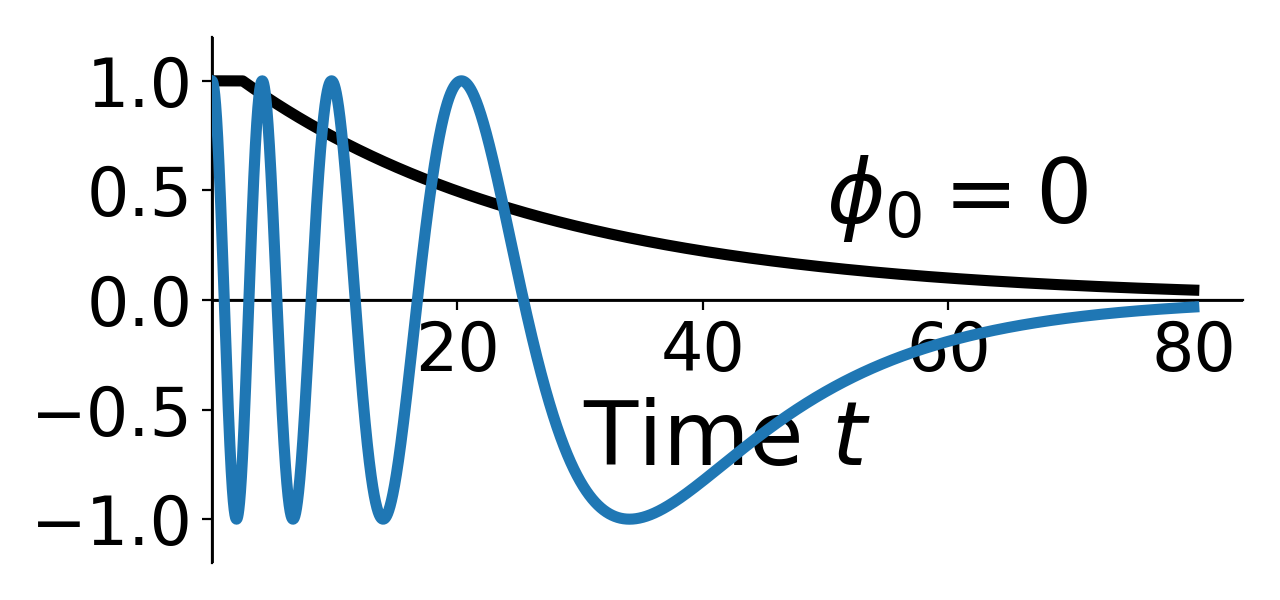

<IPython.core.display.Javascript object>


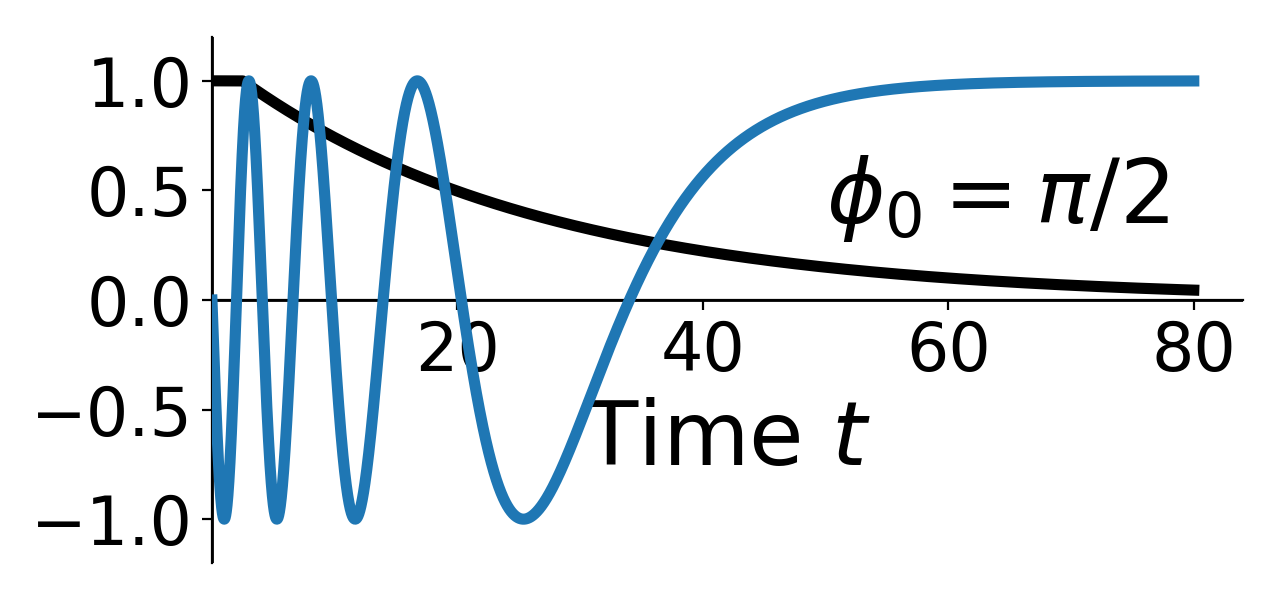

In [9]:
# Generate two representative trajectories with different initial phases
param["n_cells"] = 1
param["init_phase"] = 0.
results_c1, g_profile_c1, omega_profile_c1, times_c1 = integrate(param)

param["n_cells"] = 1
param["init_phase"] = 0.5*np.pi
results_c2, g_profile_c2, omega_profile_c2, times_c2 = integrate(param)



# Plot the first representative trajectory
plt.rcParams["figure.figsize"] = 6.4, 3.
fig, ax = plt.subplots()

ax.plot(times_c1, results_c1, c='tab:blue', lw=4, label='$\cos(\phi)$', zorder=10)
ax.plot(times_c1, g_profile_c1, c='k', lw=4, label='$g$', zorder=8)

# Move bottom x-axis to center, and eliminate upper and right axes
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Other plot options
ax.set_xlabel('Time $t$', fontsize=32)
ax.set_ylim([-1.2,1.2])
ax.set_xlim([0.,param["total_t"]+4.])
ax.axhline(linewidth=1, color='k')
ax.axvline(linewidth=1, color='k')
ax.set_yticks([-1., -0.5, 0., 0.5, 1.])
ax.set_xticks([20., 40., 60., 80.])
ax.tick_params(labelsize=24)
# ax.legend(fontsize=24, edgecolor='k')
ax.text(50., 0.35, '$\phi_0=0.$', fontsize=32)

fig.tight_layout()
fig.show()




# Plot the second representative trajectory
plt.rcParams["figure.figsize"] = 6.4, 3.
fig, ax = plt.subplots()

ax.plot(times_c2, results_c2, c='tab:blue', lw=4, label='$\cos(\phi)$', zorder=10)
ax.plot(times_c2, g_profile_c2, c='k', lw=4, label='$g$', zorder=8)

# Move bottom x-axis to center, and eliminate upper and right axes
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Other plot options
ax.set_xlabel('Time $t$', fontsize=32)
ax.set_ylim([-1.2,1.2])
ax.set_xlim([0.,param["total_t"]+4.])
ax.axhline(linewidth=1, color='k')
ax.axvline(linewidth=1, color='k')
ax.set_yticks([-1., -0.5, 0., 0.5, 1.])
ax.set_xticks([20., 40., 60., 80.])
ax.tick_params(labelsize=24)
# ax.legend(fontsize=24, edgecolor='k')
ax.text(50., 0.35, '$\phi_0=\pi/2$', fontsize=32)

fig.tight_layout()
fig.show()